In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from PIL import Image
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Organize data into train, valid, test dirs
os.chdir('data/sign_language')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [2]:
train_path = 'data/sign_language/train'
valid_path = 'data/sign_language/valid'
test_path = 'data/sign_language/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)  # shuffle = False, so we can later appropiately dispaly results on CM

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [3]:
# nothing

In [3]:
mobile = keras.models.load_model('models/mobilenet.h5')

In [4]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [5]:
# we’re going to grab the output from the sixth to last 
# layer of the model and store it in this variable x
x = mobile.layers[-6].output
output = Dense(units=10, activation='softmax')(x)
# This x might look strange... so hence mobilenet is a functional model
# So (x) means, pass to the last Dense layer all of the previous layers stored in x
# SO The output is all that is stored in x up to the last Desne layer

In [6]:
model = Model(inputs=mobile.input, outputs=output)

In [7]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [9]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=10,
            verbose=2
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 172 steps, validate for 30 steps
Epoch 1/10
172/172 - 10s - loss: 0.8200 - accuracy: 0.7482 - val_loss: 1.0733 - val_accuracy: 0.7133
Epoch 2/10
172/172 - 4s - loss: 0.1180 - accuracy: 0.9877 - val_loss: 0.8061 - val_accuracy: 0.7667
Epoch 3/10
172/172 - 4s - loss: 0.0417 - accuracy: 0.9994 - val_loss: 0.7393 - val_accuracy: 0.8033
Epoch 4/10
172/172 - 4s - loss: 0.0226 - accuracy: 1.0000 - val_loss: 0.7109 - val_accuracy: 0.7700
Epoch 5/10
172/172 - 4s - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.6505 - val_accuracy: 0.8000
Epoch 6/10
172/172 - 4s - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.6322 - val_accuracy: 0.7933
Epoch 7/10
172/172 - 4s - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.6011 - val_accuracy: 0.7900
Epoch 8/10
172/172 - 4s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.5545 - val_accuracy: 0.8033
Epoch 9/10
172/172 - 4s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.5321 - val_accuracy: 0.8033
Epoch 

In [12]:
model.save('models/mobilenet_sign_language.h5') 

In [13]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [14]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 3 2 0]
 [0 0 0 0 3 0 0 2 0 0]]


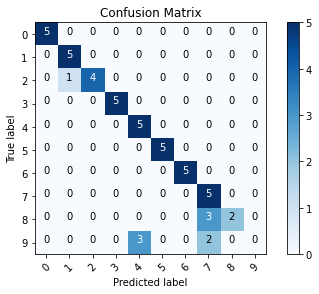

In [17]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [21]:
predictions.argmax(axis=1)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 7, 7, 8,
       7, 7, 4, 4, 4, 7], dtype=int64)